In [163]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [164]:
data_dir = pathlib.Path('flower_photos')

In [165]:
jpg_count = len(list(data_dir.glob('*/*.jpg')))
allfile_count = len(list(data_dir.glob('*/*')))
print(jpg_count)
print(allfile_count)

3670
3670


flower_photos\roses\10090824183_d02c613f10_m.jpg


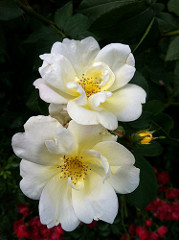

In [166]:
roses = list(data_dir.glob('roses/*'))
print(roses[0])
PIL.Image.open(roses[0])

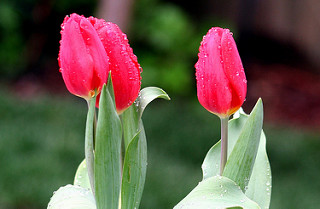

In [167]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(tulips[0])

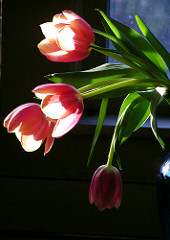

In [168]:
PIL.Image.open(tulips[20])

### Create a dataset

In [169]:
batch_size = 32
img_height = 180
img_width = 180

In [170]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


In [171]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data

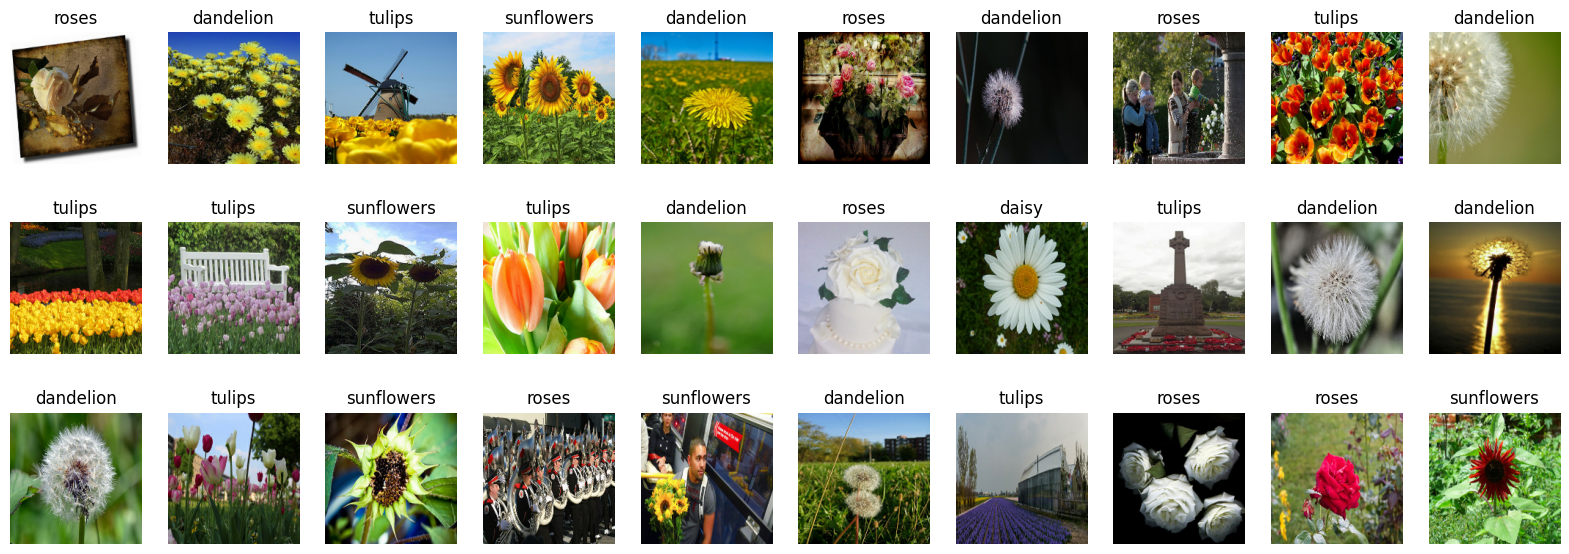

In [172]:
plt.figure(figsize=(20, 7))
for images, labels in train_ds.take(1):
  for i in range(30):
    ax = plt.subplot(3, 10, i + 1)
    plt.title(class_names[labels[i]])
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [173]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [174]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [175]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9363255


##### Keras layers API https://keras.io/api/layers/
##### Image augmentation layers https://keras.io/api/layers/preprocessing_layers/image_augmentation/

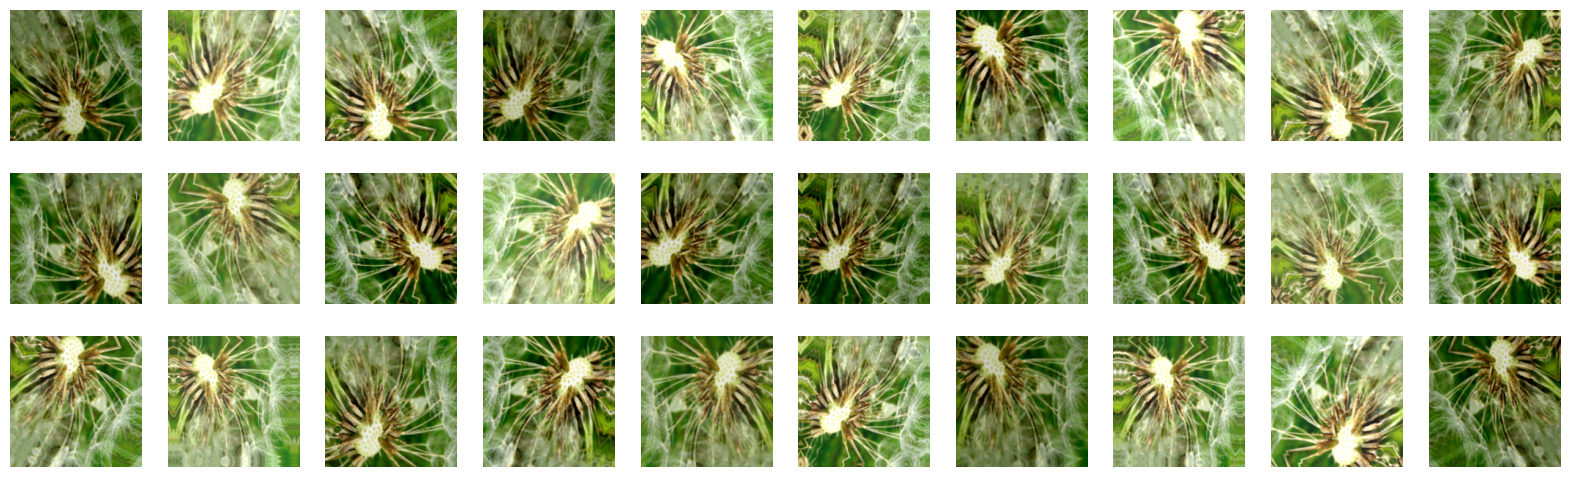

In [176]:
data_augmentation = keras.Sequential([
        # layers.RandomCrop(0.2, 0.2),
        layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
        layers.RandomTranslation(0.05, 0.05, input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(factor=0.2),
    ])
plt.figure(figsize=(20, 6))
for images, _ in train_ds.take(1):
    for i in range(30):
        ax = plt.subplot(3, 10, i + 1)
        # plt.imshow(images[i].numpy().astype("uint8"))
        augmented_images = data_augmentation(images)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [177]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_61 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

### Train the model

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

## Visualize training results

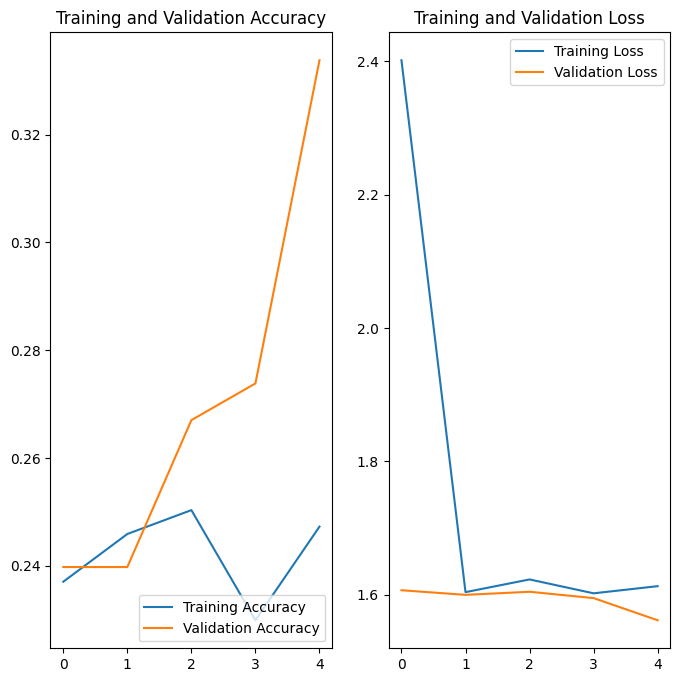

In [179]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Predict on new data

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

117948/117948 [==============================] - 0s 0us/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 252ms/step


This image most likely belongs to sunflowers with a 99.89 percent confidence.


In [ ]:
import cv2
import numpy as np
from keras import models

In [ ]:
img = cv2.cvtColor(cv2.resize(cv2.imread('1.jpg'), (180, 180)), cv2.COLOR_BGR2RGB)
img_array4 = img[np.newaxis, :]
model = models.load_model('model_name.h5')

In [ ]:
predictions = model.predict(img_array4)

In [ ]:
predictions


In [ ]:
type(predictions)

In [ ]:
print(predictions[0])

In [ ]:
exp = [2.7**x for x in predictions[0]]
[round(x*100/sum(exp)) for x in exp]

In [ ]:
class_names